# Final Project: Markovian Betweenness Centralities

A jupyter notebook for the final project. We will be comparing betweeness calculated using geodesic path and one (or two) random walk approaches. 

Methods:
1. Geodesic path approach - computed using iGraph
2. Biased random walk towards geodesic path. 
   * Set a bias term $\beta$ that describes the probability of selecting a shortest path (with probability $n^{-1}$ for each geodesic node)
   * Compute $n^{-1} (1-\beta)$ for $n$ neighbors as the probability of selecting the non-geodesic path over $n$ neighbors
   
Let's only consider an undirected graph.

"When you're nearing 50 you don't have to do math anymore" - Steve, programmer

In [8]:
import pandas as pd
import numpy as np
import igraph
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import scipy.stats as stats
import timeit
from Computational_Backend import rw_betweenness # The markov chain stuff is here
from Utils import normal_min_max

In [9]:
network_df = pd.read_csv('ecolitfnet.txt',  
                         sep = '\t', 
                        names = ['tf', 'target'])
network_graph = igraph.Graph.TupleList(network_df.values.tolist())
verbose = False  # A boolean to determine debug info and diagnostic plots
network_df.head()

,tf,target
0,ADA,AIDB
1,ADIY,GADX
2,ALLR,ALLS
3,ARCA,BETI
4,ARCA,DPIA


In [10]:
graph_components = network_graph.clusters(mode='weak')

component_sizes = graph_components.sizes() # Get a list of the component sizes
np_components = np.array(component_sizes)
largest_idx = np.argmax(np_components) #Numpy!
largest_size = np.max(np_components)
print('The largest component has index ' + str(largest_idx))
print('The largest component has size ' + str(largest_size))

giant_component_members = list()
for index, component in enumerate(graph_components.membership):
    if component == largest_idx:
        giant_component_members.append(index)

print('The component we made has ' + str(len(giant_component_members)) + 
      ' vertices.')

large_connected_inds = network_graph.vs(giant_component_members)
network_sg = network_graph.subgraph(large_connected_inds)
if verbose:
    igraph.drawing.plot(network_sg, bbox=[0,0,500,500])

The largest component has index 0
The largest component has size 122
The component we made has 122 vertices.


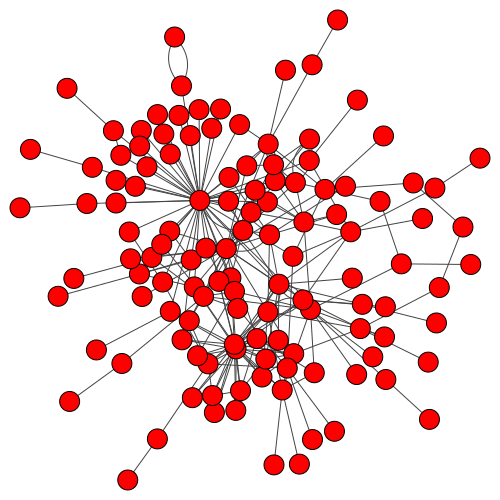

In [11]:
igraph.drawing.plot(network_sg, bbox=[0,0,500,500])

### Betweenness with geodesic paths

In [12]:
betweenness_igraph = network_sg.betweenness()

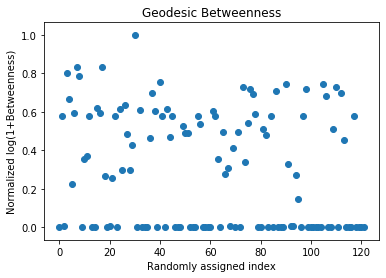

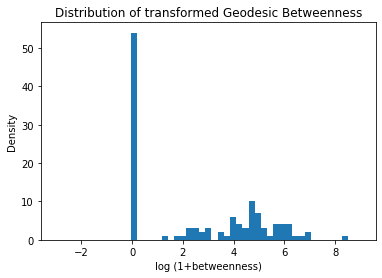

In [33]:
# scatter plot
scatter_fig = plt.figure()
plt.scatter(range(len(betweenness_igraph)),normal_min_max(np.log1p(np.array(betweenness_igraph))))
plt.ylabel('Normalized log(1+Betweenness)')
plt.xlabel('Randomly assigned index')
plt.title('Geodesic Betweenness')
plt.savefig('fig1A.png')
plt.show()

# histogram
plt.hist(np.log1p(betweenness_igraph), bins=np.linspace(-3,9))
plt.xlabel('log (1+betweenness)')
plt.ylabel('Density')
plt.title('Distribution of transformed Geodesic Betweenness')
plt.savefig('fig1B.png')

plt.show()

### Betweenness with random walks

In [17]:
np.random.seed()
start_time = timeit.default_timer()
rw_betw = rw_betweenness(graph=network_sg, beta=0.6, num_samples=10)
elapsed_time= timeit.default_timer() - start_time
#print(rw_betw)

77.10791154392064
122
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120]),)


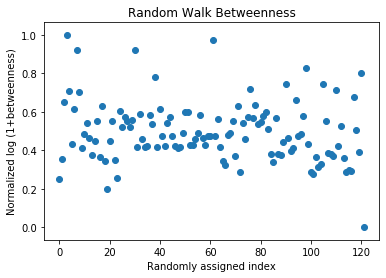

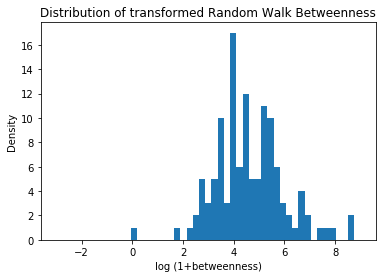

In [29]:
print(elapsed_time)
print(len(rw_betw))
print(np.nonzero(rw_betw))
# Let's make a scatter plot
scatter_fig = plt.figure()
plt.scatter(range(rw_betw.shape[0]),normal_min_max(np.log1p(rw_betw)))

plt.ylabel('Normalized log (1+betweenness)')
plt.xlabel('Randomly assigned index')
plt.title('Random Walk Betweenness')
plt.savefig('fig2A.png')
plt.show()

# Let's make a histogram
plt.hist(np.log1p(rw_betw), bins=np.linspace(-3,9))
plt.xlabel('Log-Betweenness')
plt.ylabel('Randomly assigned index')
plt.xlabel('log (1+betweenness)')
plt.ylabel('Density')
plt.title('Distribution of transformed Random Walk Betweenness')
plt.savefig('fig2B.png')
plt.show()

In [19]:
differences = np.log1p(rw_betw) - np.log1p(betweenness_igraph)

The following plots look at the difference between the RW betweenness and the igraph implemented geodesic path betweenness. 

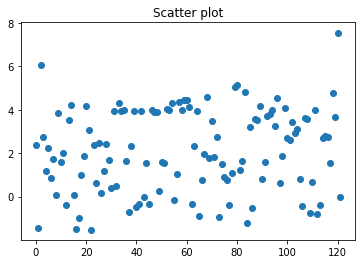

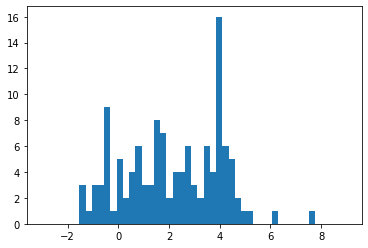

In [32]:
# Let's make a scatter plot of the differences of the log(1+betweenness)
plt.scatter(range(rw_betw.shape[0]),differences)
plt.title('Scatter plot')
plt.savefig('scatter')
plt.show()

# Histogram of these values
plt.hist(differences, bins=np.linspace(-3,9))
plt.show()

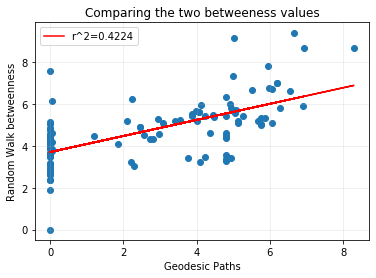

In [24]:
# Let's do a quick linear model between the 2
linear_model_all = stats.linregress(x=np.log1p(betweenness_igraph), y=np.log1p(rw_betw))
log1p_igraph = np.log1p(betweenness_igraph)

plt.scatter(np.log1p(betweenness_igraph), np.log1p(rw_betw))
plt.ylabel('Random Walk betweenness')
plt.xlabel('Geodesic Paths')
plt.title('Comparing the two betweeness values')
plt.grid(b=True, alpha=0.25)
plt.plot(log1p_igraph, linear_model_all.intercept + linear_model_all.slope*log1p_igraph, 'r', label='r^2='+str(np.round(linear_model_all.rvalue ** 2, 4)))
#Add the linear regression model with all data
plt.savefig('fig3A.png')
plt.legend()
plt.show()

In [97]:
linear_model_all

LinregressResult(slope=0.38292003706053923, intercept=3.7304168574143066, rvalue=0.6522343017772779, pvalue=4.0166099329545393e-16, stderr=0.04062496715522088)